In [15]:
# Імпортуємо бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [16]:
# Налаштування стилю
sns.set(style='whitegrid')

In [17]:
# Зчитування та обробка даних
df = pd.read_csv('_ab_test_data.csv')

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['test_group'] = df['test_group'].str.upper()

In [18]:
# Розрахунок базових метрик
summary = df.groupby('test_group')['conversion'].agg(['count', 'sum', 'mean']).reset_index()
summary.columns = ['Group', 'Total Users', 'Conversions', 'Conversion Rate']

start_date = df['timestamp'].min()
end_date = df['timestamp'].max()
duration = (end_date - start_date).days + 1

print("Результати A/B тесту:")
print(f'Період: {start_date} - {end_date} ({duration} днів)\n')
print(f'{summary}\n')

Результати A/B тесту:
Період: 2023-07-03 01:42:34.033708 - 2023-07-25 01:41:19.152664 (22 днів)

  Group  Total Users  Conversions  Conversion Rate
0     A        10013          611         0.061021
1     B         9985          889         0.089034



In [19]:
# Статистичний тест
conv_a = summary.loc[summary['Group'] == 'A', 'Conversions'].values[0]
users_a = summary.loc[summary['Group'] == 'A', 'Total Users'].values[0]
no_conv_a = users_a - conv_a

conv_b = summary.loc[summary['Group'] == 'B', 'Conversions'].values[0]
users_b = summary.loc[summary['Group'] == 'B', 'Total Users'].values[0]
no_conv_b = users_b - conv_b

In [20]:
# Створюємо матрицю спостережень
T = np.array([
    [conv_a, no_conv_a],
    [conv_b, no_conv_b]
])

In [22]:
# Виконуємо тест Хі-квадрат
chi2_stat, p_value, dof, expected = stats.chi2_contingency(T, correction=False)

print(f'Обраний критерій: Chi-Square Test (Pearson)')
print(f'Chi2 Statistic: {chi2_stat:.4f}')
print(f'p-value: {p_value:.4f}\n')

alpha = 0.05
if p_value < alpha:
    print('Відхиляємо нульову гіпотезу. Різниця значуща.')
else:
    print('Не можемо відхилити нульову гіпотезу. Різниця випадкова.\n')

Обраний критерій: Chi-Square Test (Pearson)
Chi2 Statistic: 56.5455
p-value: 0.0000

Відхиляємо нульову гіпотезу. Різниця значуща.


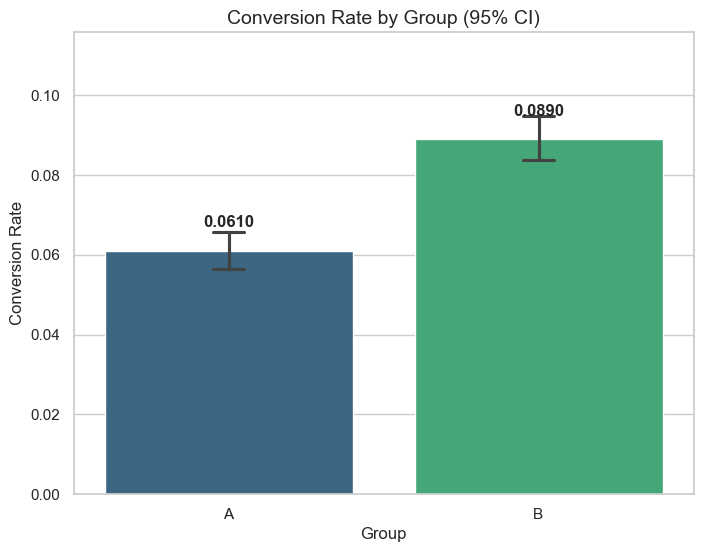

In [25]:
# Візуалізація
plt.figure(figsize=(8, 6))

ax = sns.barplot(x='test_group', y='conversion', data=df, 
                 capsize=.1, palette="viridis", hue='test_group', errorbar=('ci', 95))

plt.title('Conversion Rate by Group (95% CI)', fontsize=14)
plt.ylabel('Conversion Rate')
plt.xlabel('Group')

# Додаємо підписи
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), 
                   textcoords = 'offset points',
                   fontsize=12, fontweight='bold')

plt.ylim(0, summary['Conversion Rate'].max() * 1.3)
plt.show()

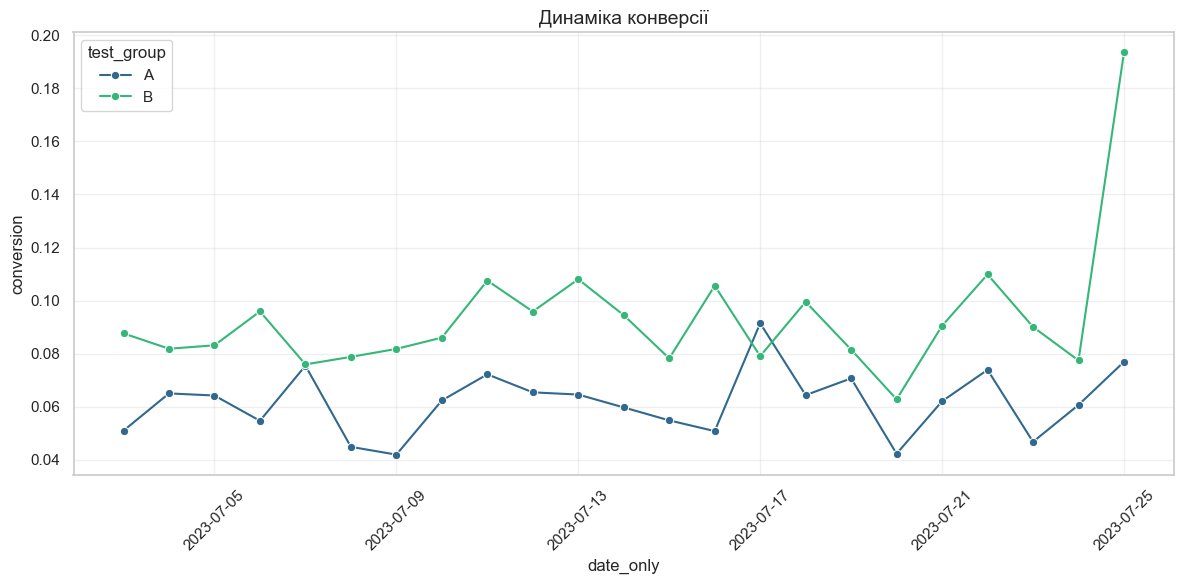

In [26]:
# Динаміка
df['date_only'] = df['timestamp'].dt.date
daily_data = df.groupby(['date_only', 'test_group'])['conversion'].mean().reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(x='date_only', y='conversion', hue='test_group', data=daily_data, marker='o', palette="viridis")

plt.title('Динаміка конверсії', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()